In [1]:
from copy import deepcopy
from pathlib import Path
import pickle
import json
from typing import Literal

from gears import PertData
import seaborn as sns
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("gene_name_map.json") as f:
    GENE_NAME_MAP = json.load(f)

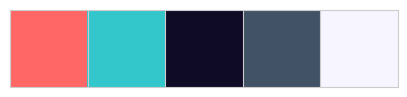

In [3]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [4]:
def _filt_self_from_de(pert_data, is_norman: bool):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20

    gene_name_to_ensg = dict(zip(pert_data.adata.var["gene_name"], pert_data.adata.var.index))
    rank_genes_groups_cov_all = deepcopy(pert_data.adata.uns[DE_COL])

    updated_rank_genes_groups_cov_all = {}

    for k, v in rank_genes_groups_cov_all.items():
        condition = k.split("_")[1]
        condition_gene_name = condition.replace("ctrl+", "").replace("+ctrl", "")

        if is_norman:
            condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
            updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
        else:
            if "+" in condition_gene_name:
                condition_gene_name = condition_gene_name.split("+")
                assert len(condition_gene_name) == 2
                condition_ensg_name = [gene_name_to_ensg.get(g, None) for g in condition_gene_name]
                mask = ~np.isin(v, condition_ensg_name)
                updated_rank_genes_groups_cov_all[k] = v[mask]
            else:
                condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
    
    return updated_rank_genes_groups_cov_all


def eval(
        pred: np.ndarray, data: dict, pert_data: PertData, is_norman: bool, key_pattern: str,
        test: bool = True):

    col = 'test_y' if test else 'val_y'

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20
    de_dict =  pert_data.adata.uns[DE_COL]
    de_dict_noself = _filt_self_from_de(pert_data, is_norman)

    ctrl = data['ctrl_mean']
    assert pred.shape[1] == ctrl.shape[0]

    cols = data[col].columns

    pearson_raw = []
    pearson_delta = []
    pearson_delta_de = []
    pearson_delta_de_no_knockout = []

    for i in range(pred.shape[0]):
        _pred = pred[i]
        _target_df = data[col].iloc[i]
        _target = data[col].iloc[i].values

        pearson_raw.append(pearsonr(_pred, _target)[0])
        pearson_delta.append(pearsonr(_pred - ctrl, _target - ctrl)[0])

        de = de_dict[key_pattern % _target_df.name][:20]
        de_pred_indices = np.array([idx for idx, i in enumerate(cols) if i in de])

        de_no_self = de_dict_noself[key_pattern % _target_df.name][:20]
        de_no_self_pred_indices = [idx for idx, i in enumerate(cols) if i in de_no_self]

        pearson_delta_de.append(
            pearsonr((_pred - ctrl)[de_pred_indices], (_target - ctrl)[de_pred_indices])[0]
        )
        pearson_delta_de_no_knockout.append(
            pearsonr((_pred - ctrl)[de_no_self_pred_indices], (_target - ctrl)[de_no_self_pred_indices])[0]
        )

    return dict(
        pearson=np.mean(pearson_raw),
        pearson_delta=np.mean(pearson_delta),
        pearson_de_delta=np.mean(pearson_delta_de),
        pearson_delta_de_no_knockout=np.mean(pearson_delta_de_no_knockout))

In [5]:
def _get_go_features(is_norman: bool, perturbation_list: list, go_pca: pd.DataFrame):

    GO_NULL_STR = "NULL"
    go_pca = go_pca.copy()
    pert_list = [i.replace("ctrl+", "").replace("+ctrl", "") for i in perturbation_list]
    if is_norman:
        # insert NULL as a row to the go_pca with 0 values
        go_pca.loc[GO_NULL_STR] = 0

        pert1 = []
        pert2 = []
        for i in pert_list:
            if '+' in i:
                p1, p2 = i.split('+')
                pert1.append(p1)
                pert2.append(p2)
            else:
                pert1.append(i)
                pert2.append('NULL')
        
        go_features = go_pca.loc[pert1].values + go_pca.loc[pert2].values

    else:

        go_features = go_pca.loc[pert_list]
    return go_features

def create_bulk_data(
    pert_data: PertData, go_pca_: pd.DataFrame, is_norman: bool):

    data_splits = deepcopy(pert_data.set2conditions)

    train_samples = data_splits['train']
    val_samples = data_splits['val']
    
    train_samples.remove('ctrl')
    if 'ctrl' in val_samples:
        val_samples.remove('ctrl')
    
    test_samples = data_splits['test']

    assert 'ctrl' not in test_samples, "ctrl in test samples"

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    train_x = _get_go_features(is_norman, train_samples, go_pca_)
    train_y = data.loc[train_samples].copy()

    val_x = _get_go_features(is_norman, val_samples, go_pca_)
    val_y = data.loc[val_samples].copy()

    test_x = _get_go_features(is_norman, test_samples, go_pca_)
    test_y = data.loc[test_samples].copy()
    ctrl_mean = data.loc['ctrl'].values

    assert train_x.shape[0] == train_y.shape[0], "Train shapes do not match"
    assert test_x.shape[0] == test_y.shape[0], "Test shapes do not match"
    assert train_x.shape[1] == test_x.shape[1], "Train and test features do not match"
    assert train_y.shape[1] == test_y.shape[1], "Train and test targets do not match"
    assert ctrl_mean.shape[0] == train_y.shape[1] == test_y.shape[1], "ctrl mean shape does not match"
    assert ctrl_mean.ndim == 1, "ctrl mean is not 1D"

    print("Number of training samples: ", train_x.shape[0])
    print("Number of test samples: ", test_x.shape[0])

    return dict(
        train_x=train_x,
        train_y=train_y,
        val_x=val_x,
        val_y=val_y,
        test_x=test_x,
        test_y=test_y,
        ctrl_mean=ctrl_mean,
    )

def hp_search(
        model_class, hp_settings: list[dict], data, pert_data, key_pattern: str, is_norman: bool, out_dir: Path):
    
    _res = dict() 
    for _hp in hp_settings:
        _model_hp_id = [f"{k}={v}" for k, v in _hp.items()]
        _model_hp_id = "_".join(_model_hp_id)

        _model = model_class(**_hp)

        _model.fit(data['train_x'], data['train_y'])
        _pred = _model.predict(data['val_x'])
        _eval = eval(_pred, data, pert_data, is_norman, key_pattern, test=False)
        print(f"HP: {_model_hp_id}")
        print(f"Validation results: {_eval}")
        print("=" * 20)
        
        _res[_model_hp_id] = dict(
            model=_model,
            eval=_eval,
        )
    # pick the best based on pearson_delta
    best_n_est = max(_res, key=lambda x: _res[x]['eval']['pearson_delta'])

    # inference on test
    _model = _res[best_n_est]['model']
    _pred = _model.predict(data['test_x'])
    _eval = eval(_pred, data, pert_data, is_norman, key_pattern, test=True)
    print(f"Best n_estimator: {_model_hp_id}")
    print(f"Test results: {_eval}")

    with open(out_dir / "test_metrics.json", "w") as f:
        json.dump(_eval, f)

    # persist best predictor
    _pred_df = pd.DataFrame(_pred, index=data['test_y'].index, columns=data['test_y'].columns)
    _pred_df.to_csv(out_dir / "predictions.csv")

    return _eval

def plot_results(df):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))

    palette = {k:v for k, v in zip(["scgpt", "mean", "rf", "en"], ['#FF6666', '#33C7CC', '#0F0A26', '#425266'])}
    sns.barplot(x='model', y='pearson_delta', data=df, ax=axs, hue='model', palette=palette)

    axs.set_title(f"Pearson Delta Results")

    plt.tight_layout()
    plt.show()


def run_models_on_dataset(
        _exp_ds_map: dict,
        _pert_data: PertData,
        _rs: int,
        _ds_name: Literal["adamson", "norman", "replogle", "replogle_rpe1"],
        _key_pattern: str,
        _res_out_dir_base: Path,

):
    _res_out_dir = _res_out_dir_base / _ds_name
    for _exp, _ds in _exp_ds_map.items():
        # random forest
        _res_dir_model = _res_out_dir / "RF" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=RandomForestRegressor,
            hp_settings=[
                dict(n_estimators=100, n_jobs=-1, random_state=_rs, verbose=True),
                dict(n_estimators=300, n_jobs=-1, random_state=_rs, verbose=True),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )
        # elastic net
        _res_dir_model = _res_out_dir / "EN" / _exp
        _res_dir_model.mkdir(parents=True, exist_ok=True)
        _res_out = hp_search(
            model_class=ElasticNet,
            hp_settings=[
                dict(alpha=0.1, l1_ratio=0.5, random_state=_rs),
                dict(alpha=0.01, l1_ratio=0.5, random_state=_rs),
            ],
            data=_ds,
            pert_data=_pert_data,
            key_pattern=_key_pattern,
            is_norman=_ds_name == "norman",
            out_dir=_res_dir_model,
        )

    # mean: does not depend on features
    mean_pred = _ds["train_y"].mean().values.reshape(1, -1)
    mean_pred = np.repeat(mean_pred, _ds["test_y"].shape[0], axis=0)

    res_mean = eval(
        pred=mean_pred,
        data=_ds,
        pert_data=_pert_data,
        key_pattern=_key_pattern,
        is_norman=_ds_name == "norman"
    )
    _res_dir_model = _res_out_dir / "mean"
    _res_dir_model.mkdir(parents=True, exist_ok=True)
    with open(_res_dir_model / "test_metrics.json", "w") as f:
        json.dump(res_mean, f)
    
    pred_df = pd.DataFrame(mean_pred, index=_ds["test_y"].index, columns=_ds["test_y"].columns)
    pred_df.to_csv(_res_dir_model / "predictions.csv")


def load_bulk_model_resutlts( dataset: str, _res_dir: Path = Path("./save")):
    res_dict = {}
    for model in ["RF", "EN"]:
        for feature in ["go", "elmo", "foundation", "gpt"]:
            with open(_res_dir / dataset / model / feature / "test_metrics.json") as f:
                res_dict[f"{model}_{feature}"] = json.load(f)
    with open(_res_dir / dataset / "mean" / "test_metrics.json") as f:
        res_dict["mean"] = json.load(f)

    return res_dict


def df_pca_transform(df, n_components=256):
    pca = PCA(n_components=n_components)
    pca_trafo = pca.fit_transform(df)
    pca_df = pd.DataFrame(pca_trafo, index=df.index)
    return pca_df

In [6]:
RANDOM_STATE = 42

RES_DIR = Path("./save")

In [7]:
go = pd.read_csv("../data/go/go_raw_matched.csv", index_col=0)
go = df_pca_transform(go, n_components=256)

sc_elmo = pd.read_parquet("../data/scElmo/ensem_emb_gpt3.5all_new.parquet")
sc_elmo = df_pca_transform(sc_elmo, n_components=256)

sc_foundation = pd.read_parquet("../data/scFoundation_embeds/embeddings.parquet")
sc_foundation = df_pca_transform(sc_foundation, n_components=256)

sc_gpt = pd.read_parquet("../data/scgpt_embeds/embeddings.parquet")
sc_gpt = df_pca_transform(sc_gpt, n_components=256)

## Adamson

In [8]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

# create dataset with go features
adamson_data_go = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
adamson_data_elmo = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
adamson_data_foundation = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
adamson_data_gpt = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=sc_gpt,
    is_norman=False,
)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22
Number of training samples:  57
Number of test samples:  22


In [9]:
dataset_exp_name_map = {
    "go": adamson_data_go,
    # "elmo": adamson_data_elmo,
    # "foundation": adamson_data_foundation,
    "gpt": adamson_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_adamson,
    _rs=RANDOM_STATE,
    _ds_name="adamson",
    _key_pattern="K562(?)_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9945441219249406, 'pearson_delta': 0.8318963903156634, 'pearson_de_delta': 0.8704487699009301, 'pearson_delta_de_no_knockout': 0.901258825367421}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9947761412204849, 'pearson_delta': 0.8387470795199571, 'pearson_de_delta': 0.8726109251759623, 'pearson_delta_de_no_knockout': 0.9027873767657025}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9925506445091282, 'pearson_delta': 0.7369380945725353, 'pearson_de_delta': 0.7433619245119748, 'pearson_delta_de_no_knockout': 0.7978781001221389}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9933054336582641, 'pearson_delta': 0.8130626961364905, 'pearson_de_delta': 0.859175824864623, 'pearson_delta_de_no_knockout': 0.8886795599861854}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9947111672880286, 'pearson_delta': 0.8217031787458283, 'pearson_de_delta': 0.8740762317073952, 'pearson_delta_de_no_knockout': 0.9033160752380293}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9924684939024164, 'pearson_delta': 0.7124145820661902, 'pearson_de_delta': 0.7521123517241456, 'pearson_delta_de_no_knockout': 0.8065876136033306}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9928868119300036, 'pearson_delta': 0.799502736140971, 'pearson_de_delta': 0.8421050065649335, 'pearson_delta_de_no_knockout': 0.869065516163662}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9930629670381826, 'pearson_delta': 0.8068305326852009, 'pearson_de_delta': 0.8465405838434542, 'pearson_delta_de_no_knockout': 0.8740397727620303}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9929120897756437, 'pearson_delta': 0.7273029042055031, 'pearson_de_delta': 0.7347285689875782, 'pearson_delta_de_no_knockout': 0.7897912995894069}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9923862685062989, 'pearson_delta': 0.783966091218412, 'pearson_de_delta': 0.8358729492908553, 'pearson_delta_de_no_knockout': 0.861980000258492}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9927456348705731, 'pearson_delta': 0.7962857697137682, 'pearson_de_delta': 0.8291103514401195, 'pearson_delta_de_no_knockout': 0.8545183329420192}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9927916181173901, 'pearson_delta': 0.718377320274029, 'pearson_de_delta': 0.737987413499592, 'pearson_delta_de_no_knockout': 0.793267495983979}


## Norman

In [10]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

# create dataset with go features
norman_data_go = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=go,
    is_norman=True,
)
# create dataset with elmo features
norman_data_elmo = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_elmo,
    is_norman=True,
)
# create dataset with sc-foundation features
norman_data_foundation = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_foundation,
    is_norman=True,
)
# create dataset with sc-gpt features
norman_data_gpt = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=sc_gpt,
    is_norman=True,
)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116
Number of training samples:  137
Number of test samples:  116


In [11]:
dataset_exp_name_map = {
    "go": norman_data_go,
    # "elmo": norman_data_elmo,
    # "foundation": norman_data_foundation,
    "gpt": norman_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_norman,
    _rs=RANDOM_STATE,
    _ds_name="norman",
    _key_pattern="A549_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9909973490031322, 'pearson_delta': 0.5925653131824634, 'pearson_de_delta': 0.4365583831724341, 'pearson_delta_de_no_knockout': 0.5199040414740576}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.991116189228655, 'pearson_delta': 0.6052250260839271, 'pearson_de_delta': 0.46683276667888024, 'pearson_delta_de_no_knockout': 0.551704988071377}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9878715174840069, 'pearson_delta': 0.5910196176315934, 'pearson_de_delta': 0.6006782893939876, 'pearson_delta_de_no_knockout': 0.6167181253586046}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9898281990671992, 'pearson_delta': 0.5706951917717613, 'pearson_de_delta': 0.5538216527723544, 'pearson_delta_de_no_knockout': 0.6389295321389734}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9908910651898456, 'pearson_delta': 0.5881500204147831, 'pearson_de_delta': 0.589037706007182, 'pearson_delta_de_no_knockout': 0.6677335187932897}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9862705244541274, 'pearson_delta': 0.534966843406766, 'pearson_de_delta': 0.557277594276753, 'pearson_delta_de_no_knockout': 0.5543372054297935}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9904901535659929, 'pearson_delta': 0.5616348636305307, 'pearson_de_delta': 0.42082496590833923, 'pearson_delta_de_no_knockout': 0.5059685088087547}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9905476652386213, 'pearson_delta': 0.576082058314612, 'pearson_de_delta': 0.4336802781801866, 'pearson_delta_de_no_knockout': 0.5218304427438313}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9877117210169063, 'pearson_delta': 0.5830636055244842, 'pearson_de_delta': 0.5857682411485321, 'pearson_delta_de_no_knockout': 0.6040582991101632}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.989278285154829, 'pearson_delta': 0.5224499983652116, 'pearson_de_delta': 0.3691249336730714, 'pearson_delta_de_no_knockout': 0.4516481828382785}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9908874659594729, 'pearson_delta': 0.5755524941934751, 'pearson_de_delta': 0.5220964045143742, 'pearson_delta_de_no_knockout': 0.6042244428679004}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9882771711443018, 'pearson_delta': 0.6143376037908795, 'pearson_de_delta': 0.6282558895771699, 'pearson_delta_de_no_knockout': 0.6487122124966559}


## Replogle

In [12]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
replogle_data_foundation = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
replogle_data_gpt = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_gpt,
    is_norman=False,
)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273
Number of training samples:  737
Number of test samples:  273


In [13]:
dataset_exp_name_map = {
    "go": replogle_data_go,
    # "elmo": replogle_data_elmo,
    # "foundation": replogle_data_foundation,
    "gpt": replogle_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_replogle,
    _rs=RANDOM_STATE,
    _ds_name="replogle",
    _key_pattern="K562_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.990356922553831, 'pearson_delta': 0.5392255802248929, 'pearson_de_delta': 0.6312167951673897, 'pearson_delta_de_no_knockout': 0.6693088663490554}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9903831982185899, 'pearson_delta': 0.5393836428836577, 'pearson_de_delta': 0.6178315189082375, 'pearson_delta_de_no_knockout': 0.6590356952811585}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9892320172266921, 'pearson_delta': 0.48060456564400567, 'pearson_de_delta': 0.5748233885537269, 'pearson_delta_de_no_knockout': 0.6003467251584177}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9871620116037044, 'pearson_delta': 0.39767645700658155, 'pearson_de_delta': 0.45913907821078165, 'pearson_delta_de_no_knockout': 0.4847662582166966}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9883611471320661, 'pearson_delta': 0.4746536621903875, 'pearson_de_delta': 0.5554345346874658, 'pearson_delta_de_no_knockout': 0.5970915728268142}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9882759600201032, 'pearson_delta': 0.4299092950243299, 'pearson_de_delta': 0.5044311696303547, 'pearson_delta_de_no_knockout': 0.5283113405995109}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9883934347138955, 'pearson_delta': 0.4511698224169352, 'pearson_de_delta': 0.530549977896256, 'pearson_delta_de_no_knockout': 0.5699250934880529}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.988527156699779, 'pearson_delta': 0.4598743355981146, 'pearson_de_delta': 0.5301239352981698, 'pearson_delta_de_no_knockout': 0.5703144467325013}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.3s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9882324703725073, 'pearson_delta': 0.4208674339582833, 'pearson_de_delta': 0.49476913572883874, 'pearson_delta_de_no_knockout': 0.5190517611445715}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.987153729095991, 'pearson_delta': 0.3969019938877059, 'pearson_de_delta': 0.4568874081588192, 'pearson_delta_de_no_knockout': 0.4831838492582919}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.987294460883459, 'pearson_delta': 0.40405943269664024, 'pearson_de_delta': 0.473644848413962, 'pearson_delta_de_no_knockout': 0.5015079243100581}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9874448176061691, 'pearson_delta': 0.37567433873942846, 'pearson_de_delta': 0.4472448484828408, 'pearson_delta_de_no_knockout': 0.4714258280247177}


## Replogle 2

In [14]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_rpe1_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:386
Done!


In [15]:
# create dataset with go features
replogle_data_go = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go,
    is_norman=False,
)
# create dataset with elmo features
replogle_data_elmo = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_elmo,
    is_norman=False,
)
# create dataset with sc-foundation features
replogle_data_foundation = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_foundation,
    is_norman=False,
)
# create dataset with sc-gpt features
replogle_data_gpt = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=sc_gpt,
    is_norman=False,
)

Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386
Number of training samples:  1041
Number of test samples:  386


In [16]:
dataset_exp_name_map = {
    "go": replogle_data_go,
    # "elmo": replogle_data_elmo,
    # "foundation": replogle_data_foundation,
    "gpt": replogle_data_gpt,
}
run_models_on_dataset(
    _exp_ds_map=dataset_exp_name_map,
    _pert_data=pert_data_replogle,
    _rs=RANDOM_STATE,
    _ds_name="replogle_rpe1",
    _key_pattern="rpe1_%s_1+1",
    _res_out_dir_base=RES_DIR
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9788693801887024, 'pearson_delta': 0.6673217881819639, 'pearson_de_delta': 0.6954850755524286, 'pearson_delta_de_no_knockout': 0.7249976106912098}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.978925563577384, 'pearson_delta': 0.6688503028964681, 'pearson_de_delta': 0.6972255740014301, 'pearson_delta_de_no_knockout': 0.7271151380505235}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9792603083087364, 'pearson_delta': 0.6478059195137752, 'pearson_de_delta': 0.6680163346886243, 'pearson_delta_de_no_knockout': 0.6819056666313817}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755651512683143, 'pearson_delta': 0.6544450209298751, 'pearson_de_delta': 0.6996542790965921, 'pearson_delta_de_no_knockout': 0.7307129450069342}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9771045803990229, 'pearson_delta': 0.6625842373534578, 'pearson_de_delta': 0.71075446419216, 'pearson_delta_de_no_knockout': 0.7423869470195016}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9775236790884488, 'pearson_delta': 0.6382634580303428, 'pearson_de_delta': 0.6733496399871391, 'pearson_delta_de_no_knockout': 0.687659518290337}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


HP: n_estimators=100_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9767720758121962, 'pearson_delta': 0.654729998004627, 'pearson_de_delta': 0.701786928888906, 'pearson_delta_de_no_knockout': 0.7306343753063317}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


HP: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Validation results: {'pearson': 0.9771239430169506, 'pearson_delta': 0.6590282143418636, 'pearson_de_delta': 0.7044586691463937, 'pearson_delta_de_no_knockout': 0.7347196599995915}


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.5s finished


Best n_estimator: n_estimators=300_n_jobs=-1_random_state=42_verbose=True
Test results: {'pearson': 0.9776718421657047, 'pearson_delta': 0.6347121980395032, 'pearson_de_delta': 0.654321554447, 'pearson_delta_de_no_knockout': 0.6661607865615438}
HP: alpha=0.1_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.9755478376941698, 'pearson_delta': 0.6544359677415377, 'pearson_de_delta': 0.6997140018336816, 'pearson_delta_de_no_knockout': 0.7307212116359939}
HP: alpha=0.01_l1_ratio=0.5_random_state=42
Validation results: {'pearson': 0.975855453015131, 'pearson_delta': 0.6549365329394908, 'pearson_de_delta': 0.7010122658093575, 'pearson_delta_de_no_knockout': 0.7319440851869294}
Best n_estimator: alpha=0.01_l1_ratio=0.5_random_state=42
Test results: {'pearson': 0.9763798699726074, 'pearson_delta': 0.6287764230167225, 'pearson_de_delta': 0.6511996992824369, 'pearson_delta_de_no_knockout': 0.6610873760585891}


## Compare scGPT, meanPredictor, RF and EN on  metrics

In [19]:
# load scgpt results
with open("./save/dev_perturb_adamson-Sep26-20-36/test_metrics.json") as f:
    adamson_scgpt = json.load(f)

with open("./save/dev_perturb_norman-Sep24-13-29/test_metrics.json") as f:
    norman_scpt = json.load(f)

with open("./save/dev_perturb_replogle-Sep24-15-06/test_metrics.json") as f:
    replogle_scgpt = json.load(f)

with open("./save/dev_perturb_replogle_rpe1-Feb25-16-55/test_metrics.json") as f:
    replogle_rpe1_scgpt = json.load(f)

# load scfoundation results
sc_foundation_base = Path("../scFoundation/GEARS/results/")
with open(sc_foundation_base / "adamson/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.0005/2025-02-12_10-47-01/test_metrics.json") as f:
    adamson_scfoundation = json.load(f)

with open(sc_foundation_base / "norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27/test_metrics.json") as f:
    norman_scfoundation = json.load(f)

with open(sc_foundation_base / "replogle_k562_essential/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-17_16-45-12/test_metrics.json") as f:
    replogle_scfoundation = json.load(f) 

In [20]:
adamson_results = load_bulk_model_resutlts("adamson")
adamson_results["scgpt"] = adamson_scgpt
adamson_results["scfoundation"] = adamson_scfoundation

norman_results = load_bulk_model_resutlts("norman")
norman_results["scgpt"] = norman_scpt
norman_results["scfoundation"] = norman_scfoundation

replogle_results = load_bulk_model_resutlts("replogle")
replogle_results["scgpt"] = replogle_scgpt
replogle_results["scfoundation"] = replogle_scfoundation

replogle_rp1_results = load_bulk_model_resutlts("replogle_rpe1")
replogle_rp1_results["scgpt"] = replogle_rpe1_scgpt


## Adamson

In [21]:
adamson_results = (
    pd.DataFrame
    .from_dict(adamson_results, orient='index')
    .reset_index()
    .rename(columns={"index": "model"})
)

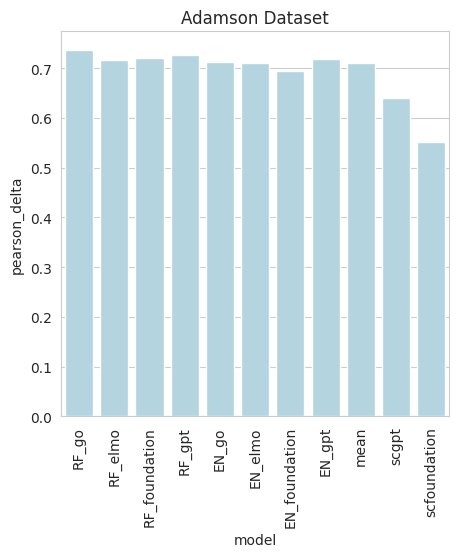

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=adamson_results, color='lightblue', ax=axs)
axs.set_title("Adamson Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

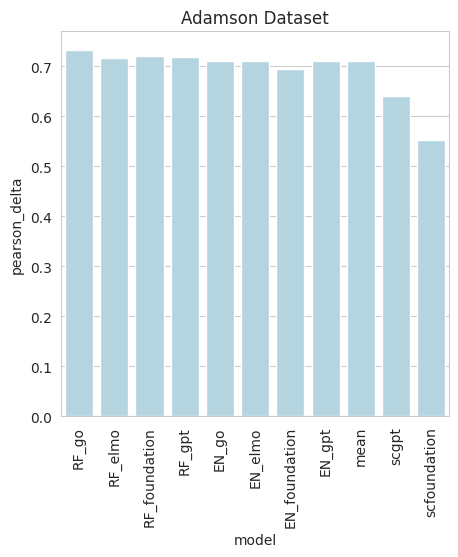

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=adamson_results, color='lightblue', ax=axs)
axs.set_title("Adamson Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

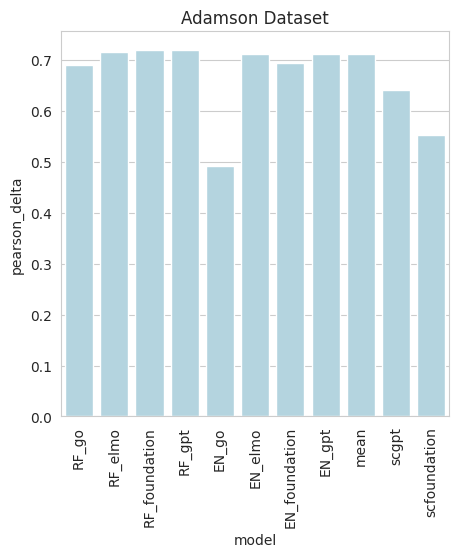

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=adamson_results, color='lightblue', ax=axs)
axs.set_title("Adamson Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Norman

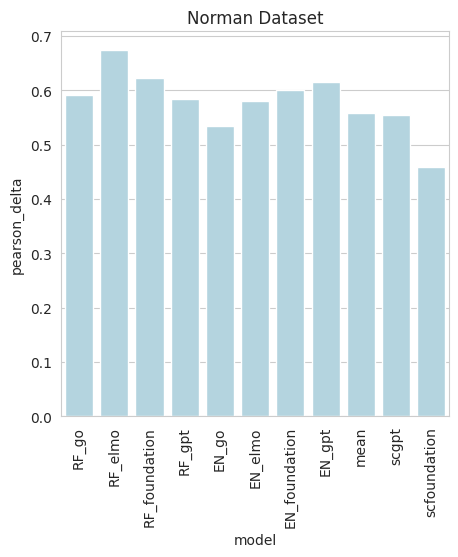

In [23]:
norman_results = pd.DataFrame.from_dict(norman_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=norman_results, color='lightblue', ax=axs)
axs.set_title("Norman Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

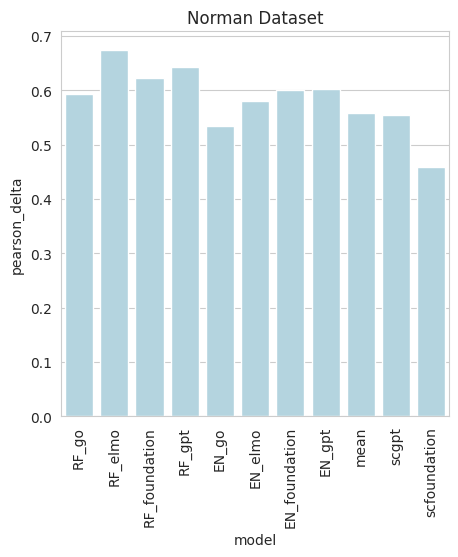

In [24]:
norman_results = pd.DataFrame.from_dict(norman_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=norman_results, color='lightblue', ax=axs)
axs.set_title("Norman Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

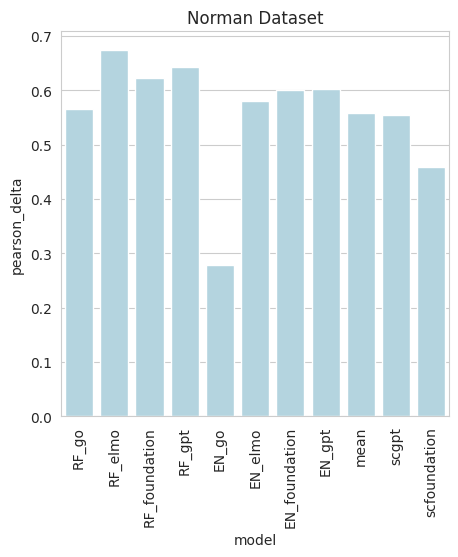

In [22]:
norman_results = pd.DataFrame.from_dict(norman_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=norman_results, color='lightblue', ax=axs)
axs.set_title("Norman Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Replogle

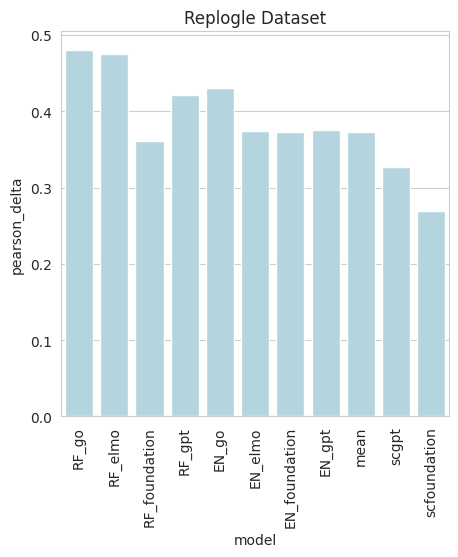

In [24]:
replogle_results = pd.DataFrame.from_dict(replogle_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_results, color='lightblue', ax=axs)
axs.set_title("Replogle Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

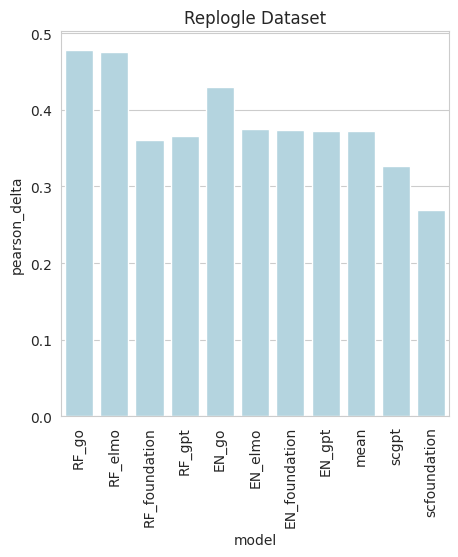

In [29]:
replogle_results = pd.DataFrame.from_dict(replogle_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_results, color='lightblue', ax=axs)
axs.set_title("Replogle Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

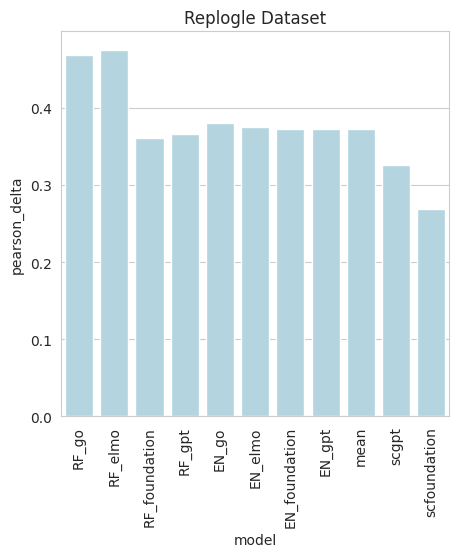

In [23]:
replogle_results = pd.DataFrame.from_dict(replogle_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_results, color='lightblue', ax=axs)
axs.set_title("Replogle Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

## Replogle RP1

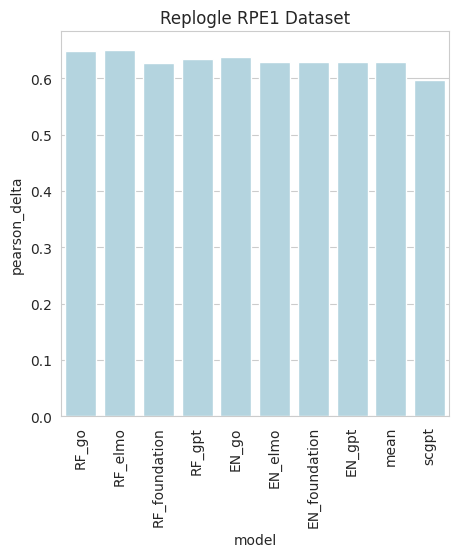

In [25]:
replogle_rp1_results = pd.DataFrame.from_dict(replogle_rp1_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_rp1_results, color='lightblue', ax=axs)
axs.set_title("Replogle RPE1 Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

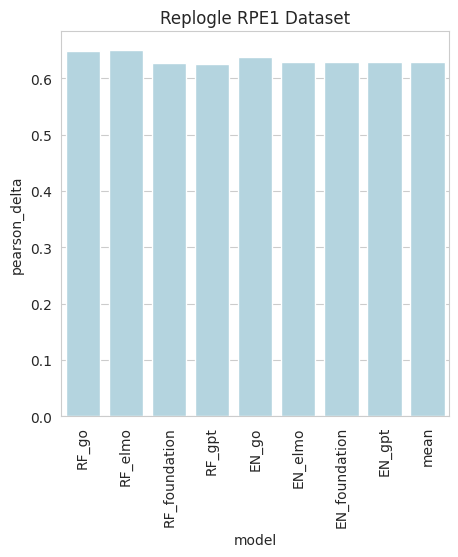

In [35]:
replogle_rp1_results = pd.DataFrame.from_dict(replogle_rp1_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_rp1_results, color='lightblue', ax=axs)
axs.set_title("Replogle RPE1 Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

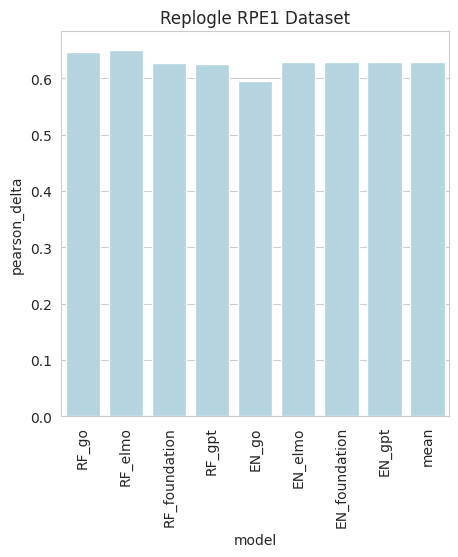

In [25]:
replogle_rp1_results = pd.DataFrame.from_dict(replogle_rp1_results, orient='index').reset_index().rename(columns={"index": "model"})
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x='model', y='pearson_delta', data=replogle_rp1_results, color='lightblue', ax=axs)
axs.set_title("Replogle RPE1 Dataset")

# rotate x labels by 90
for tick in axs.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
df = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    mean=adamson_res_mean,
    rf=adamson_res_rf,
    en=adamson_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

plot_results(df)

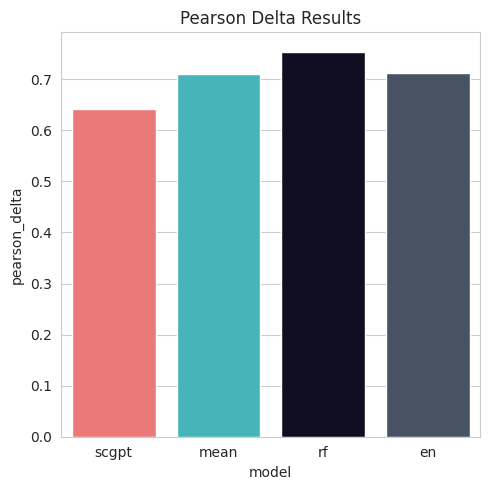

In [27]:
df = pd.DataFrame.from_dict(dict(
    scgpt=adamson_scgpt,
    mean=adamson_res_mean,
    rf=adamson_res_rf,
    en=adamson_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

plot_results(df)

## Norman

In [8]:
# load norman results
with open("./save/norman/RF/go/test_metrics.json") as f:
    norman_res_rf = json.load(f)

with open("./save/norman/RF/elmo/test_metrics.json") as f:
    norman_res_rf_elmo = json.load(f)

with open("./save/norman/EN/go/test_metrics.json") as f:
    norman_res_en = json.load(f)

with open("./save/norman/EN/elmo/test_metrics.json") as f:
    norman_res_en_elmo = json.load(f)

with open("./save/norman/mean/go/test_metrics.json") as f:
    norman_res_mean = json.load(f)

with open("./save/norman/mean/elmo/test_metrics.json") as f:
    norman_res_mean_elmo = json.load(f)

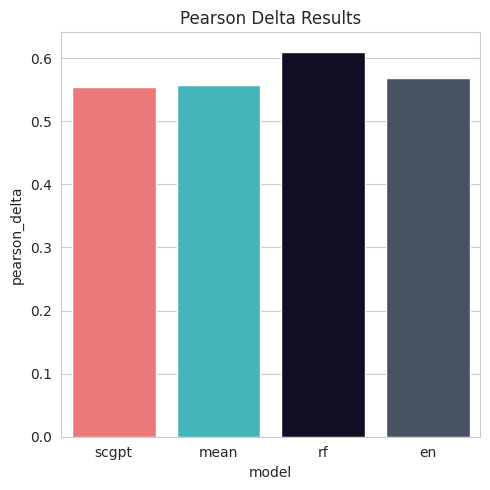

In [10]:
df = pd.DataFrame.from_dict(dict(
    scgpt=norman_scpt,
    mean=norman_res_mean,
    rf=norman_res_rf,
    en=norman_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})
plot_results(df)

<Axes: xlabel='model', ylabel='pearson_delta'>

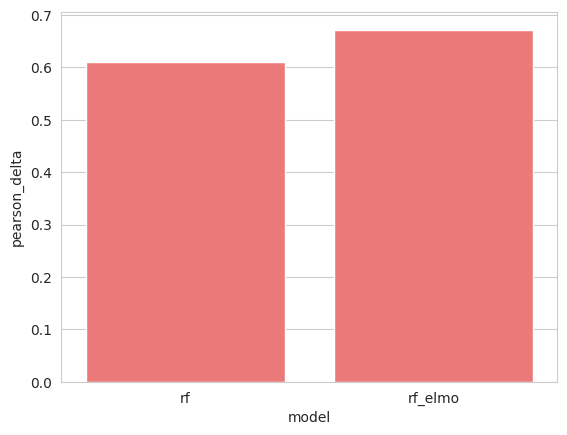

In [12]:
df = pd.DataFrame.from_dict(dict(
    rf=norman_res_rf,
    rf_elmo=norman_res_rf_elmo,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

sns.barplot(x='model', y='pearson_delta', data=df)

In [15]:
df = pd.DataFrame.from_dict(dict(
    scgpt=norman_scpt,
    mean=norman_res_mean,
    rf=norman_res_rf,
    en=norman_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})

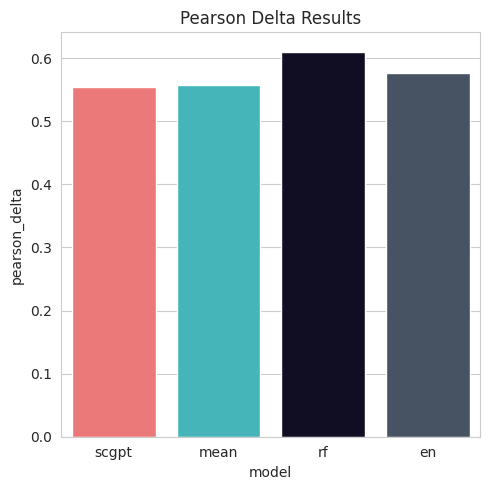

In [16]:
plot_results(df)

## Replogle

In [30]:
df = pd.DataFrame.from_dict(dict(
    scgpt=replogle_scgpt,
    mean=replogle_res_mean,
    rf=replogle_res_rf,
    en=replogle_res_en,
), orient='index')
df = df.reset_index().rename(columns={"index": "model"})


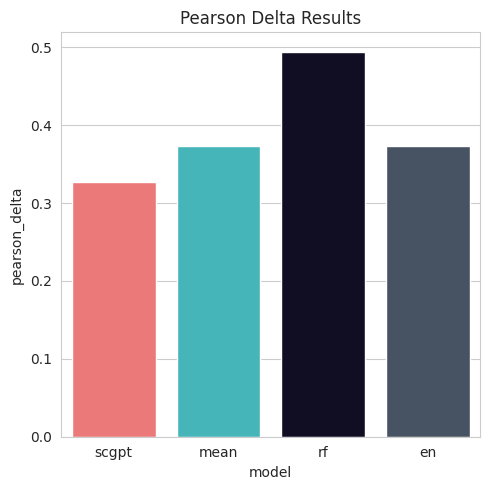

In [31]:
plot_results(df)

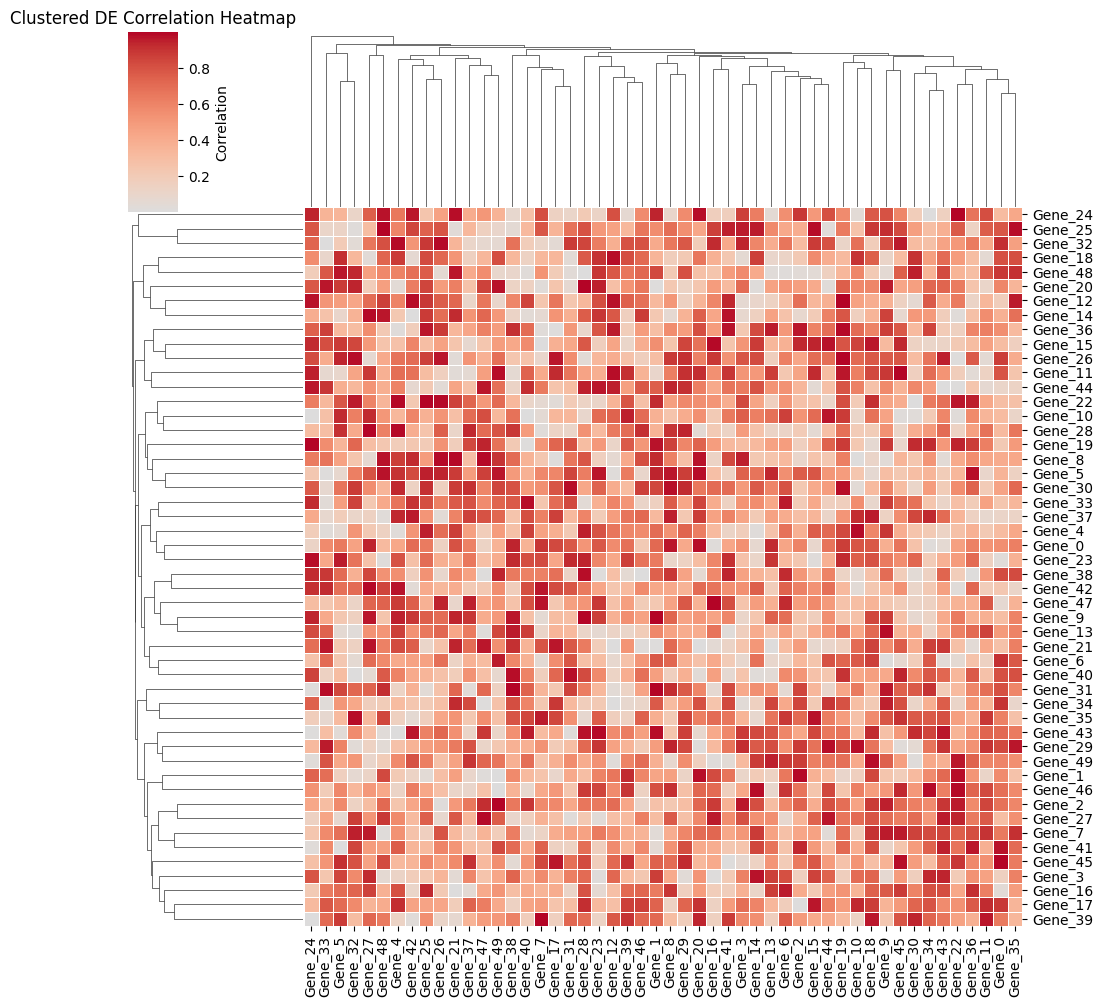

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example: Generate synthetic correlation data
np.random.seed(0)
data = np.random.rand(50, 50)  # Replace with your actual correlation matrix
df = pd.DataFrame(data, columns=[f"Gene_{i}" for i in range(50)], index=[f"Gene_{i}" for i in range(50)])

# Clustered heatmap
g = sns.clustermap(df, cmap="coolwarm", center=0, linewidths=0.5, figsize=(10, 10),
                   xticklabels=True, yticklabels=True, cbar_kws={'label': 'Correlation'})

plt.title("Clustered DE Correlation Heatmap")
plt.show()
